In [1]:
!pip install ipypb
!pip install --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-w_kxyxu0/polara_2cdbb86a6666476c835e6e635748755d
  Running command git clone --filter=blob:none --quiet https://github.com/evfro/polara.git /tmp/pip-install-w_kxyxu0/polara_2cdbb86a6666476c835e6e635748755d
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Resolved https://github.com/evfro/polara.git to commit 8e48cfd88e616ca53f8bbda1702a3e2c8abaf38e
  Preparing metadata (setup.py) ... done
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=89455 sha256=e3a98e97fbe8df4c8876d90383f081af65aa02fbc382159a2bd24852be4f1731
  Stored in directory: /tmp/pip-ephem-

In [2]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm

import torch
import torch.nn as nn

from polara import get_movielens_data
from polara.preprocessing.dataframes import reindex, leave_one_out

In [3]:
def fix_torch_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
import numpy as np
import pandas as pd


def downvote_seen_items(scores, data, data_description):
    assert isinstance(scores, np.ndarray), 'Scores must be a dense numpy array!'
    itemid = data_description['items']
    userid = data_description['users']
    # get indices of observed data, corresponding to scores array
    # we need to provide correct mapping of rows in scores array into
    # the corresponding user index (which is assumed to be sorted)
    row_idx, test_users = pd.factorize(data[userid], sort=True)
    assert len(test_users) == scores.shape[0]
    col_idx = data[itemid].values
    # downvote scores at the corresponding positions
    scores[row_idx, col_idx] = scores.min() - 1


def topn_recommendations(scores, topn=20):
    recommendations = np.apply_along_axis(topidx, 1, scores, topn)
    return recommendations


def topidx(a, topn):
    parted = np.argpartition(a, -topn)[-topn:]
    return parted[np.argsort(-a[parted])]


def model_evaluate(recommended_items, holdout, holdout_description, topn=20):
    itemid = holdout_description['items']
    holdout_items = holdout[itemid].values
    assert recommended_items.shape[0] == len(holdout_items)
    hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
    # HR calculation
    hr = np.mean(hits_mask.any(axis=1))
    # MRR calculation
    n_test_users = recommended_items.shape[0]
    hit_rank = np.where(hits_mask)[1] + 1.0
    mrr = np.sum(1 / hit_rank) / n_test_users
    # coverage calculation
    n_items = holdout_description['n_items']
    cov = np.unique(recommended_items).size / n_items
    return hr, mrr, cov


def calculate_rmse(scores, holdout, holdout_description):
    user_idx = np.arange(holdout.shape[0])
    item_idx = holdout[holdout_description['items']].values
    feedback = holdout[holdout_description['feedback']].values
    predicted_rating = scores[user_idx, item_idx]
    return np.mean(np.abs(predicted_rating-feedback)**2)

In [5]:
from scipy.sparse import csr_matrix
import pandas as pd


def leave_last_out(data, userid='userid', timeid='timestamp'):
    data_sorted = data.sort_values('timestamp')
    holdout = data_sorted.drop_duplicates(
        subset=['userid'], keep='last'
    ) # split the last item from each user's history
    remaining = data.drop(holdout.index) # store the remaining data - will be our training
    return remaining, holdout


def transform_indices(data, users, items):
    '''
    Reindex columns that correspond to users and items.
    New index is contiguous starting from 0.

    Parameters
    ----------
    data : pandas.DataFrame
        The input data to be reindexed.
    users : str
        The name of the column in `data` that contains user IDs.
    items : str
        The name of the column in `data` that contains item IDs.

    Returns
    -------
    pandas.DataFrame, dict
        The reindexed data and a dictionary with mapping between original IDs and the new numeric IDs.
        The keys of the dictionary are 'users' and 'items'.
        The values of the dictionary are pandas Index objects.

    Examples
    --------
    >>> data = pd.DataFrame({'customers': ['A', 'B', 'C'], 'products': ['X', 'Y', 'Z'], 'rating': [1, 2, 3]})
    >>> data_reindexed, data_index = transform_indices(data, 'customers', 'products')
    >>> data_reindexed
       users  items  rating
    0      0      0       1
    1      1      1       2
    2      2      2       3
    >>> data_index
    {
        'users': Index(['A', 'B', 'C'], dtype='object', name='customers'),
        'items': Index(['X', 'Y', 'Z'], dtype='object', name='products')
    }
    '''
    data_index = {}
    for entity, field in zip(['users', 'items'], [users, items]):
        new_index, data_index[entity] = to_numeric_id(data, field)
        data = data.assign(**{f'{field}': new_index}) # makes a copy of dataset!
    return data, data_index


def to_numeric_id(data, field):
    """
    This function takes in two arguments, data and field. It converts the data field
    into categorical values and creates a new contiguous index. It then creates an
    idx_map which is a renamed version of the field argument. Finally, it returns the
    idx and idx_map variables. 
    """
    idx_data = data[field].astype("category")
    idx = idx_data.cat.codes
    idx_map = idx_data.cat.categories.rename(field)
    return idx, idx_map


def reindex_data(data, data_index, fields=None):
    '''
    Reindex provided data with the specified index mapping.
    By default, will take the name of the fields to reindex from `data_index`.
    It is also possible to specify which field to reindex by providing `fields`.
    '''
    if fields is None:
        fields = data_index.keys()
    if isinstance(fields, str): # handle single field provided as a string
        fields = [fields]
    for field in fields:
        entity_name = data_index[field].name
        new_index = data_index[field].get_indexer(data[entity_name])
        data = data.assign(**{f'{entity_name}': new_index}) # makes a copy of dataset!
    return data


def generate_interactions_matrix(data, data_description, rebase_users=False):
    '''
    Converts a pandas dataframe with user-item interactions into a sparse matrix representation.
    Allows reindexing user ids, which help ensure data consistency at the scoring stage
    (assumes user ids are sorted in the scoring array).
    
    Args:
        data (pandas.DataFrame): The input dataframe containing the user-item interactions.
        data_description (dict): A dictionary containing the data description with the following keys:
            - 'n_users' (int): The total number of unique users in the data.
            - 'n_items' (int): The total number of unique items in the data.
            - 'users' (str): The name of the column in the dataframe containing the user ids.
            - 'items' (str): The name of the column in the dataframe containing the item ids.
            - 'feedback' (str): The name of the column in the dataframe containing the user-item interaction feedback.
        rebase_users (bool, optional): Whether to reindex the user ids to make contiguous index starting from 0. Defaults to False.

    Returns:
        scipy.sparse.csr_matrix: A sparse matrix of shape (n_users, n_items) containing the user-item interactions.
    '''
        
    n_users = data_description['n_users']
    n_items = data_description['n_items']
    # get indices of observed data
    user_idx = data[data_description['users']].values
    if rebase_users: # handle non-contiguous index of test users
        # This ensures that all user ids are contiguous and start from 0,
        # which helps ensure data consistency at the scoring stage.
        user_idx, user_index = pd.factorize(user_idx, sort=True)
        n_users = len(user_index)
    item_idx = data[data_description['items']].values
    feedback = data[data_description['feedback']].values
    # construct rating matrix
    return csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items))


def verify_time_split(before, after, target_field='userid', timeid='timestamp'):
    '''
    Check that items from `after` dataframe have later timestamps than
    any corresponding item from the `before` dataframe. Compare w.r.t target_field.
    Usage example: assert that for any user, the holdout items are the most recent ones.
    '''
    before_ts = before.groupby(target_field)[timeid].max()
    after_ts = after.groupby(target_field)[timeid].min()
    assert (
        before_ts
        .reindex(after_ts.index)
        .combine(after_ts, lambda x, y: True if x!=x else x <= y)
    ).all()



def timepoint_split(data, time_split_q=0.95):
    """
    Split data into training, testset, and holdout datasets based on a timepoint split
    and according to the `warm-start` evaluation strategy.

    Parameters
    ----------
    data : pd.DataFrame
        The input dataset containing columns `userid`, `movieid`, and `timestamp`.
    time_split_q : float, optional
        The quantile value used to split the dataset based on the `timestamp` column.
        Default is 0.95.

    Returns
    -------
    Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
        A tuple of three pandas DataFrames: training, testset, and holdout.
        `training` is a subset of `data` used for training the recommender system.
        `testset` is a subset of `data` used for generating recommendations for the test users.
        `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

    Notes
    -----
    The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
    The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
    The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
    The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
    """    
    timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
    test_ = data.query('timestamp >= @timepoint')
    rest_ = data.drop(test_.index)
    holdout_ = (
        test_
        .sort_values('timestamp')
        .drop_duplicates(subset=['userid'], keep='first')
    )
    # the holdout dataframe contains interactions closest to certain timepoint from the right,
    # i.e., the corresponding items are the first in each test user profile after this timepoint
    training = rest_.query('userid not in @holdout_.userid')
    train_items = training.itemid.unique()
    testset_ = rest_.query('userid in @holdout_.userid and itemid in @train_items')
    test_users = testset_.userid.unique()
    holdout = holdout_.query(
        # if user is not in `test_users` then no evluation is possible,
        # if item is not in `train_items` it's cold start -> must be excluded
        'userid in @test_users and itemid in @train_items'
    ).sort_values('userid')
    testset = testset_.query(
        # make sure testset and holdout contain the same set of users
        'userid in @holdout.userid'
    ).sort_values('userid')
    return training, testset, holdout

# Preparing data

In [6]:
!mkdir data
!wget https://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip -d data

--2023-03-29 16:46:25--  https://files.grouplens.org/datasets/movielens/ml-1m.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5917549 (5.6M) [application/zip]
Saving to: ‘ml-1m.zip’

ml-1m.zip           100%[===================>]   5.64M  3.41MB/s    in 1.7s    

2023-03-29 16:46:28 (3.41 MB/s) - ‘ml-1m.zip’ saved [5917549/5917549]

Archive:  ml-1m.zip
   creating: data/ml-1m/
  inflating: data/ml-1m/movies.dat   
  inflating: data/ml-1m/ratings.dat  
  inflating: data/ml-1m/README       
  inflating: data/ml-1m/users.dat    


In [7]:
movielens = pd.read_csv("data/ml-1m/ratings.dat", sep="::", names=["userid", "itemid", "rating", "timestamp"], engine="python")

In [8]:
movielens.nunique()

userid         6040
itemid         3706
rating            5
timestamp    458455
dtype: int64

In [9]:
_train, _test, _holdout = timepoint_split(movielens, time_split_q=0.95)

len(_train), len(_test), len(_holdout)

(725370, 221697, 802)

In [10]:
def reindex_all(train, test, holdout=None, userid='userid', itemid='itemid'):
    train_new, data_index = transform_indices(train, userid, itemid)
    test_new = reindex_data(test, data_index, fields='items')
    
    if holdout is None:
        return train_new, test_new, data_index
    
    holdout_new = reindex_data(holdout, data_index, fields='items')
    return train_new, test_new, holdout_new, data_index

In [11]:
train, test, holdout, data_index = reindex_all(_train, _test, _holdout)

We sample the last item for each test user.  
As all these users are excluded from the training, and training is additionally filtered by timestamp,
there will be no "recommendation from future" issue - our model is unaware of future correlations.


In [12]:
testset_, holdout_ = leave_one_out(
    test, target='timestamp', sample_top=True, random_state=0
)
testset_valid_, holdout_valid_ = leave_one_out(
    testset_, target='timestamp', sample_top=True, random_state=0
)

Let's focus on validation part.

In [13]:
userid = data_index['users'].name
test_users = pd.Index(
    # ensure test users are the same across testing data
    np.intersect1d(
        testset_valid_[userid].unique(),
        holdout_valid_[userid].unique()
    )
)
testset_valid = (
    testset_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)
holdout_valid = (
    holdout_valid_
    # reindex warm-start users for convenience
    .assign(**{userid: lambda x: test_users.get_indexer(x[userid])})
    .query(f'{userid} >= 0')
    .sort_values('userid')
)

In [14]:
testset_valid.nunique()

userid          801
itemid         3420
rating            5
timestamp    113490
dtype: int64

In [15]:
holdout_valid.shape

(801, 4)

In [16]:
assert holdout_valid.set_index('userid')['timestamp'].ge(
    testset_valid
    .groupby('userid')
    ['timestamp'].max()
).all()

In [17]:
data_description = dict(
    users = data_index['users'].name,
    items = data_index['items'].name,
    order = 'timestamp',
    feedback = 'rating',
    n_users = len(data_index['users']),
    n_items = len(data_index['items']),
)
data_description

{'users': 'userid',
 'items': 'itemid',
 'order': 'timestamp',
 'feedback': 'rating',
 'n_users': 5227,
 'n_items': 3652}

# Batch Sampler

In [18]:
def sequential_batch_sampler(user_train, usernum, itemnum, batch_size, maxlen, seed, pad_token=None):
    if pad_token is None:
        pad_token = itemnum
    
    def sample(random_state):
        user = random_state.randint(usernum)
        while len(user_train.get(user, [])) <= 1:
            user = random_state.randint(usernum)
        user_items = user_train[user]
        seq = np.full(maxlen, pad_token, dtype=np.int32)
        pos = np.full(maxlen, pad_token, dtype=np.int32)
        neg = np.full(maxlen, pad_token, dtype=np.int32)
        nxt = user_items[-1]
        idx = maxlen - 1
        ts = set(user_items)
        for i in reversed(user_items[:-1]):
            seq[idx] = i
            pos[idx] = nxt
            neg[idx] = random_neq(0, itemnum, ts, random_state)
            nxt = i
            idx -= 1
            if idx == -1:
                break
        return (user, seq, pos, neg)
    
    random_state = np.random.RandomState(seed)
    while True:
        yield zip(*(sample(random_state) for _ in range(batch_size)))


def random_neq(l, r, s, random_state):
    t = random_state.randint(l, r)
    while t in s:
        t = random_state.randint(l, r)
    return t

# SASRec model

The code is adapted from https://github.com/pmixer/SASRec.pytorch

In [19]:
class PointWiseFeedForward(nn.Module):
    def __init__(self, hidden_units, dropout_rate):
        super(PointWiseFeedForward, self).__init__()
        self.conv1 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv1d(hidden_units, hidden_units, kernel_size=1)
        self.dropout2 = nn.Dropout(p=dropout_rate)

    def forward(self, inputs):
        outputs = self.dropout2(self.conv2(self.relu(self.dropout1(self.conv1(inputs.transpose(-1, -2))))))
        outputs = outputs.transpose(-1, -2) # as Conv1D requires (N, C, Length)
        outputs += inputs
        return outputs


class SASRec(nn.Module):
    def __init__(self, item_num, config):
        super(SASRec, self).__init__()
        self.item_num = item_num
        self.pad_token = item_num

        self.item_emb = nn.Embedding(self.item_num+1, config['hidden_units'], padding_idx=self.pad_token)
        self.pos_emb = nn.Embedding(config['maxlen'], config['hidden_units'])
        self.emb_dropout = nn.Dropout(p=config['dropout_rate'])

        self.attention_layernorms = nn.ModuleList() # to be Q for self-attention
        self.attention_layers = nn.ModuleList()
        self.forward_layernorms = nn.ModuleList()
        self.forward_layers = nn.ModuleList()
        self.last_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)

        for _ in range(config['num_blocks']):
            new_attn_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.attention_layernorms.append(new_attn_layernorm)
            new_attn_layer =  nn.MultiheadAttention(
                config['hidden_units'],config['num_heads'],config['dropout_rate']
            )
            self.attention_layers.append(new_attn_layer)

            new_fwd_layernorm = nn.LayerNorm(config['hidden_units'], eps=1e-8)
            self.forward_layernorms.append(new_fwd_layernorm)

            new_fwd_layer = PointWiseFeedForward(config['hidden_units'], config['dropout_rate'])
            self.forward_layers.append(new_fwd_layer)
        
        fix_torch_seed(config['manual_seed'])
        self.initialize()


    def initialize(self):
        for name, param in self.named_parameters():
            try:
                torch.nn.init.xavier_uniform_(param.data)
            except:
                pass # just ignore those failed init layers


    def log2feats(self, log_seqs):
        device = log_seqs.device
        seqs = self.item_emb(log_seqs)
        seqs *= self.item_emb.embedding_dim ** 0.5
        positions = np.tile(np.arange(log_seqs.shape[1]), [log_seqs.shape[0], 1])
        seqs += self.pos_emb(torch.LongTensor(positions).to(device))
        seqs = self.emb_dropout(seqs)

        timeline_mask = log_seqs == self.pad_token
        seqs *= ~timeline_mask.unsqueeze(-1) # broadcast in last dim

        tl = seqs.shape[1] # time dim len for enforce causality
        attention_mask = ~torch.tril(torch.full((tl, tl), True, device=device))

        for i in range(len(self.attention_layers)):
            seqs = torch.transpose(seqs, 0, 1)
            Q = self.attention_layernorms[i](seqs)
            mha_outputs, _ = self.attention_layers[i](
                Q, seqs, seqs, attn_mask=attention_mask
            )
        
            seqs = Q + mha_outputs
            seqs = torch.transpose(seqs, 0, 1)

            seqs = self.forward_layernorms[i](seqs)
            seqs = self.forward_layers[i](seqs)
            seqs *=  ~timeline_mask.unsqueeze(-1)

        log_feats = self.last_layernorm(seqs) # (U, T, C) -> (U, -1, C)

        return log_feats

    def forward(self, log_seqs, pos_seqs, neg_seqs):
        log_feats = self.log2feats(log_seqs)
        pos_embs = self.item_emb(pos_seqs)
        neg_embs = self.item_emb(neg_seqs)

        pos_logits = (log_feats * pos_embs).sum(dim=-1)
        neg_logits = (log_feats * neg_embs).sum(dim=-1)

        return pos_logits, neg_logits


    def score(self, seq):
        '''
        Takes 1d sequence as input and returns prediction scores.
        '''
        maxlen = self.pos_emb.num_embeddings
        log_seqs = torch.full([maxlen], self.pad_token, dtype=torch.int64, device=seq.device)
        log_seqs[-len(seq):] = seq[-maxlen:]
        log_feats = self.log2feats(log_seqs.unsqueeze(0))
        final_feat = log_feats[:, -1, :] # only use last QKV classifier

        item_embs = self.item_emb.weight
        logits = item_embs.matmul(final_feat.unsqueeze(-1)).squeeze(-1)
        return logits

## Training 

In [20]:
def data_to_sequences(data, data_description):
    userid = data_description['users']
    itemid = data_description['items']
    sequences = (
        data.sort_values([userid, data_description['order']])
        .groupby(userid, sort=False)[itemid].apply(list)
    )
    return sequences

In [21]:
def prepare_sasrec_model(config, data, data_description):
    n_users = data_description['n_users']    
    n_items = data_description['n_items']    
    model = SASRec(n_items, config)
    criterion = torch.nn.BCEWithLogitsLoss()
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()

    train_sequences = data_to_sequences(data, data_description)
    sampler = sequential_batch_sampler(
        train_sequences, n_users, n_items,
        batch_size = config['batch_size'],
        maxlen = config['maxlen'],
        seed = config['sampler_seed'],
        pad_token = model.pad_token
    )
    n_batches = len(train_sequences) // config['batch_size']
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr = config['learning_rate'],
        betas = (0.9, 0.98)
    )
    return model, sampler, n_batches, criterion, optimizer

In [22]:
def train_sasrec_epoch(model, num_batch, l2_emb, sampler, optimizer, criterion, device):
    model.train()
    pad_token = model.pad_token
    losses = []
    for _ in range(num_batch):
        _, *seq_data = next(sampler)
        # convert batch data into torch tensors
        seq, pos, neg = (torch.LongTensor(np.array(x)).to(device) for x in seq_data)
        pos_logits, neg_logits = model(seq, pos, neg)
        pos_labels = torch.ones(pos_logits.shape, device=device)
        neg_labels = torch.zeros(neg_logits.shape, device=device)
        optimizer.zero_grad()
        indices = torch.where(pos != pad_token)
        loss = criterion(pos_logits[indices], pos_labels[indices])
        loss += criterion(neg_logits[indices], neg_labels[indices])
        if l2_emb != 0:
            for param in model.item_emb.parameters():
                loss += l2_emb * torch.norm(param)**2
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    return losses

In [23]:
def build_sasrec_model(config, data, data_description):
    '''Simple MF training routine without early stopping'''
    model, sampler, n_batches, criterion, optimizer = prepare_sasrec_model(config, data, data_description)
    device = 'cpu'
    if torch.cuda.is_available():
        device = torch.device(f'cuda:{torch.cuda.current_device()}') 
    losses = {}
    for epoch in tqdm(range(config['num_epochs'])):
        losses[epoch] = train_sasrec_epoch(
            model, n_batches, config['l2_emb'], sampler, optimizer, criterion, device
        )
    return model, losses

In [24]:
config = dict(
    num_epochs = 20,
    maxlen = 200,
    hidden_units = 64,
    dropout_rate = 0.4,
    num_blocks = 1,
    num_heads = 1,
    batch_size = 64,
    sampler_seed = 99,
    manual_seed = 111,
    learning_rate = 1e-3,
    l2_emb = 0,
)

In [25]:
model, losses = build_sasrec_model(config, train, data_description)

  0%|          | 0/20 [00:00<?, ?it/s]

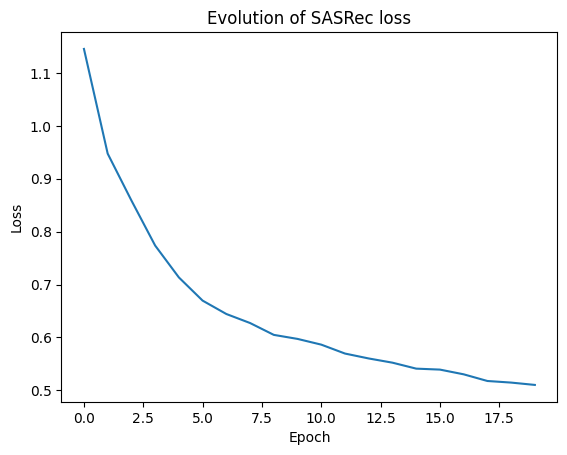

In [26]:
pd.Series(losses).apply(np.mean).plot(title='Evolution of SASRec loss', xlabel='Epoch', ylabel='Loss');

/usr/local/lib/python3.9/dist-packages/pandas/plotting/_matplotlib/core.py:1114: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = ax.scatter(


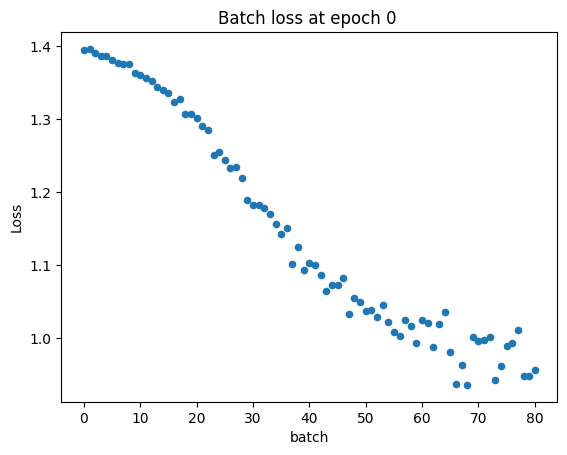

In [27]:
epoch = 0
epoch_loss_series = pd.Series(losses[epoch], name='Loss').rename_axis('batch')
ax = epoch_loss_series.reset_index().plot.scatter(
    x='batch', y='Loss', title=f'Batch loss at epoch {epoch} '
)

# Evaluation

In [28]:
def sasrec_model_scoring(params, data, data_description):
    model = params
    model.eval()
    tensor = torch.cuda.LongTensor if torch.cuda.is_available() else torch.LongTensor
    test_sequences = data_to_sequences(data, data_description)
    # perform scoring on a user-batch level
    scores = []
    for _, seq in test_sequences.items():
        with torch.no_grad():
            predictions = model.score(tensor(seq))
        scores.append(predictions.detach().cpu().numpy())
    return np.concatenate(scores, axis=0)

In [29]:
sasrec_scores = sasrec_model_scoring(model, test, data_description)

In [30]:
downvote_seen_items(sasrec_scores, test, data_description)

In [31]:
sasrec_recs = topn_recommendations(sasrec_scores, topn=20)
model_evaluate(sasrec_recs, holdout, data_description)

(0.08977556109725686, 0.02862826058455406, 0.4482475355969332)